In [1]:
import sys
sys.path.append("..")
REF_PATH = "/home/yifan/dataset/resnet18_init/pairflip/cifar10/0"
CLEAN_PATH = "/home/yifan/dataset/resnet18_with_dropout/pairflip/cifar10/0/"
DEVICE ="cpu"
from AlignVis.DataInit import DataInit
import numpy as np
REF_EPOCH = 200
TAR_EPOCH = 200
ref_datainit = DataInit(REF_PATH,REF_PATH,REF_EPOCH,DEVICE)
tar_datainit = DataInit(CLEAN_PATH,CLEAN_PATH,TAR_EPOCH,DEVICE)
####### get border points
ref_model, ref_provider, ref_train_data, ref_prediction, ref_prediction_res, ref_scores = ref_datainit.getData()
tar_model, tar_provider, tar_train_data, tar_prediction, tar_prediction_res, tar_scores = tar_datainit.getData()

/home/yifan/miniconda3/envs/deepdebugger/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


NET resnet18
Finish initialization...


RuntimeError: CUDA error: out of memory
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

In [11]:
from alignment.ReferenceGenerator import ReferenceGenerator
gen = ReferenceGenerator(ref_provider=ref_provider, tar_provider=tar_provider,REF_EPOCH=REF_EPOCH,TAR_EPOCH=TAR_EPOCH,ref_model=ref_model,tar_model=tar_model,DEVICE=DEVICE)

absolute_alignment_indicates,predict_label_diff_indicates,predict_confidence_Diff_indicates,high_distance_indicates = gen.subsetClassify(18,0.8,0.3,0.05)

100%|██████████| 250/250 [00:00<00:00, 8290.45it/s]


absolute alignment indicates number: 167 label diff indicates number: 13 confidence diff indicates number: 15 high distance number: 75


In [12]:
need_adjusted_indicates = np.concatenate((predict_label_diff_indicates, predict_confidence_Diff_indicates),axis=0)

In [13]:
from AlignVis.aproximate_ref_generator import ApproximateRefGenerator
aeg = ApproximateRefGenerator(ref_provider=ref_provider, tar_provider=tar_provider, REF_EPOCH=REF_EPOCH,TAR_EPOCH=TAR_EPOCH, tar_model=tar_model, ref_model=ref_model,DEVICE=DEVICE)

100%|██████████| 250/250 [00:00<00:00, 8280.50it/s]


In [ ]:
newRep = aeg.generate_representation_by_cka(need_adjusted_indicates)

In [16]:
from CKA_utils.CKA import CKA, CudaCKA
np_cka = CKA()

print('CKA between absolute alignmnet subset is:',np_cka.kernel_CKA(newRep,tar_train_data[need_adjusted_indicates]))

CKA between absolute alignmnet subset is: 0.9999993882392624


In [17]:
print('reference predict res: ', ref_prediction_res[need_adjusted_indicates])
print('adjusetd ref  predict res: ', ref_provider.get_pred(200, newRep).argmax(axis=1))
print('adjusetd ref  predict res: ', tar_provider.get_pred(200, newRep).argmax(axis=1))
print('target        predict res: ', tar_prediction_res[need_adjusted_indicates])

reference predict res:  [5 4 3 4 3 3 5 3 7 5 3 5 1 3 2 0 4 6 4 7 7 4 4 4 7 1 1 3]


100%|██████████| 1/1 [00:00<00:00, 3196.88it/s]


adjusetd ref  predict res:  [7 4 3 2 3 0 3 3 7 3 4 5 0 3 2 0 4 6 4 5 7 2 3 6 7 1 1 3]


100%|██████████| 1/1 [00:00<00:00, 2601.93it/s]

adjusetd ref  predict res:  [7 5 3 2 5 0 3 5 5 3 4 5 0 3 2 0 4 6 4 7 4 3 4 4 4 1 1 3]
target        predict res:  [7 5 5 2 5 0 3 5 5 3 4 7 0 3 2 0 4 6 4 7 7 4 4 4 7 1 1 3]


In [9]:
len(need_adjusted_indicates)

28

In [ ]:
####### generate boundary ponits for tar and ref respectively
from AlignVis.AlignmentBoundaryGenerator import AlignmentBoundaryGenerator
BoundaryGen = AlignmentBoundaryGenerator(REF_PATH,CLEAN_PATH,REF_PATH,CLEAN_PATH,REF_EPOCH,TAR_EPOCH,DEVICE)
ref_boundary,tar_boundary = BoundaryGen.get_boundary_point(DEVICE,num_adv_eg=10000)

In [20]:
import torch
###### get border sample features
import torch.nn as nn

ref_feature_model = ref_model.to(DEVICE)
ref_feature_model = nn.Sequential(*list(ref_feature_model.children())[:-1])
with torch.no_grad():
    features = ref_feature_model(ref_boundary)
    ref_features = features.view(ref_boundary.shape[0], -1).cpu().numpy()

In [21]:
###### get border sample features
import torch.nn as nn
tar_feature_model = tar_model.to(DEVICE)
tar_feature_model = nn.Sequential(*list(tar_feature_model.children())[:-1])
with torch.no_grad():
    tar_features = tar_feature_model(tar_boundary)
    tar_features = tar_features.view(tar_boundary.shape[0], -1).cpu().numpy()

In [22]:
from CKA_utils.CKA import CKA, CudaCKA
np_cka = CKA()
# indicates = np.random.choice(aligned, size=10, replace=False)
indicates = np.random.choice(np.arange(5000), size=100, replace=False)
print('CKA between absolute alignmnet subset is:',np_cka.kernel_CKA(ref_features[indicates],tar_features[indicates]))

CKA between absolute alignmnet subset is: 0.805491619313475


In [23]:
tar_border_pre = tar_provider.get_pred(TAR_EPOCH, tar_features)
ref_border_pre = ref_provider.get_pred(REF_EPOCH, ref_features)

100%|██████████| 50/50 [00:00<00:00, 13899.47it/s]


In [24]:
tar_border_pre_r = tar_provider.get_pred(TAR_EPOCH, tar_features).argmax(axis=1)
ref_border_pre_r = ref_provider.get_pred(REF_EPOCH, ref_features).argmax(axis=1)

100%|██████████| 50/50 [00:00<00:00, 13930.86it/s]


In [25]:
border_aligned = []
for i in range(len(tar_border_pre_r)):
    if tar_border_pre_r[i] == ref_border_pre_r[i]:
        border_aligned.append(i)



In [26]:
len(border_aligned)

8231

In [27]:
###### get aligned border points
aligned_border_ref = ref_features[border_aligned]
aligned_border_tar = tar_features[border_aligned]

In [30]:
indicates = np.random.choice(np.arange(5000), size=100, replace=False)
print('CKA between absolute alignmnet subset is:',np_cka.kernel_CKA(aligned_border_ref[indicates],aligned_border_tar[indicates]))

CKA between absolute alignmnet subset is: 0.8319767650614158


In [26]:
import os
import json
with open('tar_border_features.json', 'w') as f:
        json.dump(tar_features.tolist(), f)

In [31]:
ENCODER_DIMS=[512,256,256,256,256,2]
DECODER_DIMS= [2,256,256,256,256,512]
VIS_MODEL_NAME = 'vis'
from representationTrans.trans_visualizer_border import visualizer
from singleVis.SingleVisualizationModel import VisModel
from singleVis.projector import TimeVisProjector
model = VisModel(ENCODER_DIMS, DECODER_DIMS)

I = np.eye(512)
projector = TimeVisProjector(vis_model=model, content_path=REF_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")
vis = visualizer(ref_provider, I,I, np.dot(ref_provider.train_representation(TAR_EPOCH),I), projector, 200,[0,1],'tab10')


In [32]:
from AlignVis.AlignMetrixGenerator import TrainingSnapshotAlignment
alignment = TrainingSnapshotAlignment(ref_provider, tar_provider,ref_EPOCH=REF_EPOCH,tar_EPOCH=TAR_EPOCH, projector=projector, visualizer=vis)

In [33]:
#### replace diff set in representations list with new generated representations
new_ref_representations = ref_train_data

for i in range(len(need_adjusted_indicates)):
    index = need_adjusted_indicates[i]
    new_ref_representations[index] = newRep[i]


In [34]:
R_n = alignment.align_embeddings_batch(tar_train_data,new_ref_representations,train_steps=15000,batch_size=100)

batch_idx 0,iteration 0, loss1 65500368.0 loss2 {tensor(0.7574, grad_fn=<AddBackward0>)} neibour_loss {tensor(0.8530, requires_grad=True)}
batch_idx 199,iteration 199, loss1 594.5850830078125 loss2 {tensor(0.5549, grad_fn=<AddBackward0>)} neibour_loss {tensor(0.5220, requires_grad=True)}
batch_idx 398,iteration 398, loss1 234.92471313476562 loss2 {tensor(0.4171, grad_fn=<AddBackward0>)} neibour_loss {tensor(0.5070, requires_grad=True)}
batch_idx 97,iteration 597, loss1 222.15773010253906 loss2 {tensor(0.3895, grad_fn=<AddBackward0>)} neibour_loss {tensor(0.4660, requires_grad=True)}
batch_idx 296,iteration 796, loss1 228.26443481445312 loss2 {tensor(0.4010, grad_fn=<AddBackward0>)} neibour_loss {tensor(0.4630, requires_grad=True)}
batch_idx 495,iteration 995, loss1 203.9058380126953 loss2 {tensor(0.3535, grad_fn=<AddBackward0>)} neibour_loss {tensor(0.4040, requires_grad=True)}
batch_idx 194,iteration 1194, loss1 197.689453125 loss2 {tensor(0.3522, grad_fn=<AddBackward0>)} neibour_loss

In [35]:
###### select high confidence sample as embedding align and all border samle 
high_confidence_indicates = []
for i in range(len(ref_scores)):
    if ref_scores[i] == 1 and tar_scores[i] == 1:
        high_confidence_indicates.append(i)
len(high_confidence_indicates)   

26513

In [23]:
low_confidence_indicates = []
for i in range(len(ref_scores)):
    if ref_scores[i] < 1 and tar_scores[i] < 1:
        low_confidence_indicates.append(i)
len(low_confidence_indicates)   

11579

In [38]:
indicates = np.random.choice(np.arange(50000), size=1000, replace=False)
ref_high_conf = np.dot(tar_train_data[high_confidence_indicates], R_n.detach().numpy())
tar_high_conf = tar_train_data[high_confidence_indicates]
X_for_s = np.concatenate((new_ref_representations,ref_features[border_aligned]),axis=0)
Y_for_s = np.concatenate((tar_train_data,tar_features[border_aligned]),axis=0)
print(len(X_for_s))
S_s = alignment.align_embeddings_batch(X_for_s,Y_for_s,train_steps=15000,batch_size=100)

58231
batch_idx 0,iteration 0, loss1 95277264.0 loss2 {tensor(0.7708, grad_fn=<AddBackward0>)} neibour_loss {tensor(0.8530, requires_grad=True)}
batch_idx 199,iteration 199, loss1 275.78082275390625 loss2 {tensor(0.6209, grad_fn=<AddBackward0>)} neibour_loss {tensor(0.5280, requires_grad=True)}
batch_idx 398,iteration 398, loss1 185.5990447998047 loss2 {tensor(0.4789, grad_fn=<AddBackward0>)} neibour_loss {tensor(0.5410, requires_grad=True)}
batch_idx 14,iteration 597, loss1 170.8916778564453 loss2 {tensor(0.4989, grad_fn=<AddBackward0>)} neibour_loss {tensor(0.4800, requires_grad=True)}
batch_idx 213,iteration 796, loss1 175.66392517089844 loss2 {tensor(0.4407, grad_fn=<AddBackward0>)} neibour_loss {tensor(0.4620, requires_grad=True)}
batch_idx 412,iteration 995, loss1 172.97427368164062 loss2 {tensor(0.4439, grad_fn=<AddBackward0>)} neibour_loss {tensor(0.4590, requires_grad=True)}
batch_idx 28,iteration 1194, loss1 109.3965835571289 loss2 {tensor(0.2997, grad_fn=<AddBackward0>)} nei

Computing decision regions ...


100%|██████████| 250/250 [00:00<00:00, 8751.26it/s]


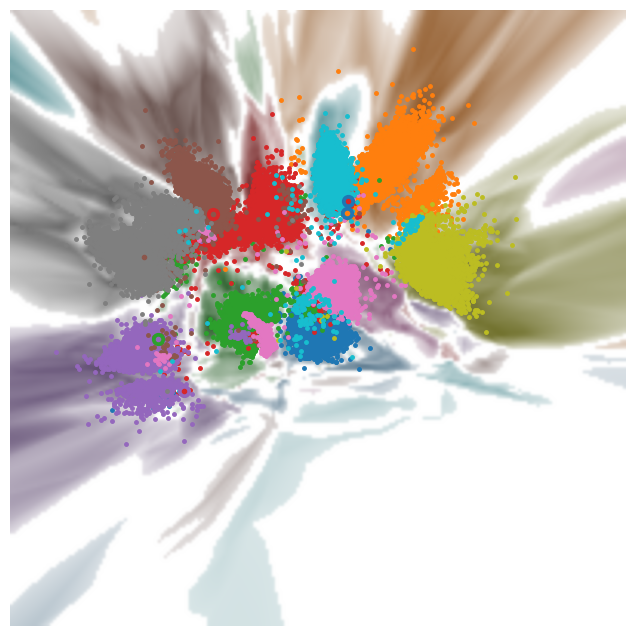

In [9]:
import json
import os
from singleVis.SingleVisualizationModel import VisModel
from singleVis.projector import TimeVisProjector
model = VisModel(ENCODER_DIMS, DECODER_DIMS)

projector = TimeVisProjector(vis_model=model, content_path=REF_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")

I = np.eye(512)
from representationTrans.trans_visualizer_border import visualizer
# from representationTrans.visualizer import visualizer
vis = visualizer(ref_provider, I,I, np.dot(ref_train_data, I), projector, 200,[],'tab10')
save_dir = os.path.join('/home/yifan/projects' , "imgcontrast")
# os.makedirs(save_dir)

vis.savefig(200, path=os.path.join("/home/yifan/projects/deepdebugertool/DLVisDebugger/alignment_evaluation/img2.png"))

Computing decision regions ...


100%|██████████| 250/250 [00:00<00:00, 8356.92it/s]


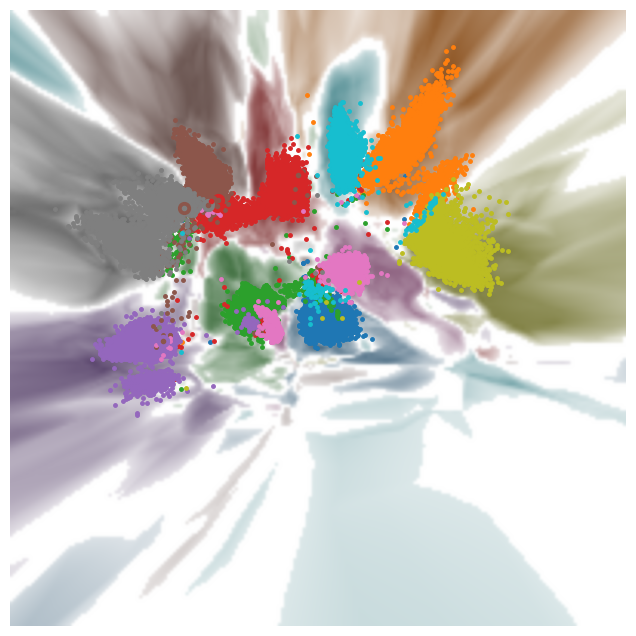

In [40]:
import json
import os
from singleVis.SingleVisualizationModel import VisModel
from singleVis.projector import TimeVisProjector
model = VisModel(ENCODER_DIMS, DECODER_DIMS)

projector = TimeVisProjector(vis_model=model, content_path=REF_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")

I = np.eye(512)
from representationTrans.trans_visualizer_border import visualizer
# from representationTrans.visualizer import visualizer
vis = visualizer(tar_provider, S_s.detach().numpy(),I, np.dot(tar_train_data, R_n.detach().numpy()), projector, 200,[],'tab10')
save_dir = os.path.join('/home/yifan/projects' , "imgcontrast")
# os.makedirs(save_dir)

vis.savefig(200, path=os.path.join("/home/yifan/projects/deepdebugertool/DLVisDebugger/alignment_evaluation/img2.png"))

In [28]:
R_n_2 = alignment.align_embeddings_batch(ref_train_data,tar_train_data,train_steps=15000,batch_size=100)

batch_idx 0,iteration 0, loss1 93985856.0 loss2 {tensor(0.7978, grad_fn=<AddBackward0>)} neibour_loss {tensor(0.8690, requires_grad=True)}
batch_idx 199,iteration 199, loss1 233.1377410888672 loss2 {tensor(0.5359, grad_fn=<AddBackward0>)} neibour_loss {tensor(0.5100, requires_grad=True)}
batch_idx 398,iteration 398, loss1 174.72117614746094 loss2 {tensor(0.4490, grad_fn=<AddBackward0>)} neibour_loss {tensor(0.4890, requires_grad=True)}
batch_idx 97,iteration 597, loss1 161.75448608398438 loss2 {tensor(0.4627, grad_fn=<AddBackward0>)} neibour_loss {tensor(0.4830, requires_grad=True)}
batch_idx 296,iteration 796, loss1 154.91165161132812 loss2 {tensor(0.4361, grad_fn=<AddBackward0>)} neibour_loss {tensor(0.4580, requires_grad=True)}
batch_idx 495,iteration 995, loss1 127.1869888305664 loss2 {tensor(0.3641, grad_fn=<AddBackward0>)} neibour_loss {tensor(0.4260, requires_grad=True)}
batch_idx 194,iteration 1194, loss1 113.2746353149414 loss2 {tensor(0.2963, grad_fn=<AddBackward0>)} neibour_

In [ ]:
indicates = np.random.choice(np.arange(50000), size=1000, replace=False)
ref_high_conf = np.dot(tar_train_data[high_confidence_indicates], R_n.detach().numpy())
tar_high_conf = tar_train_data[high_confidence_indicates]
X_for_s = np.concatenate((ref_train_data[indicates],ref_features[border_aligned]),axis=0)
Y_for_s = np.concatenate((tar_train_data[indicates],tar_features[border_aligned]),axis=0)
print(len(X_for_s))
S_s_2 = alignment.align_embeddings_batch(Y_for_s,X_for_s,train_steps=5000,batch_size=100)

Computing decision regions ...


100%|██████████| 250/250 [00:00<00:00, 8636.37it/s]


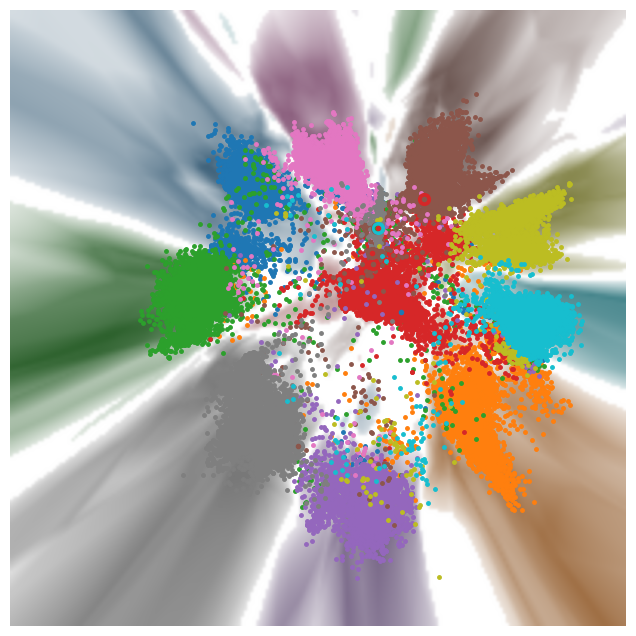

In [27]:
import json
import os
from singleVis.SingleVisualizationModel import VisModel
from singleVis.projector import TimeVisProjector
model = VisModel(ENCODER_DIMS, DECODER_DIMS)

projector = TimeVisProjector(vis_model=model, content_path=CLEAN_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")

I = np.eye(512)
from representationTrans.trans_visualizer_border import visualizer
# from representationTrans.visualizer import visualizer
vis = visualizer(ref_provider, R_n.detach().numpy(),I, np.dot(ref_train_data, S_s.detach().numpy()), projector, 200,[],'tab10')
save_dir = os.path.join('/home/yifan/projects' , "imgcontrast")
# os.makedirs(save_dir)

vis.savefig(200, path=os.path.join("/home/yifan/projects/deepdebugertool/DLVisDebugger/alignment_evaluation/img2.png"))

Computing decision regions ...


100%|██████████| 200/200 [00:00<00:00, 2053.08it/s]
../representationTrans/trans_visualizer_border.py:186: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  train_data = self.data_provider.train_representation(epoch)[self.indicates]
../representationTrans/trans_visualizer_border.py:187: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  train_labels = self.data_provider.train_labels(epoch)[self.indicates]
../representationTrans/trans_visualizer_border.py:188: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; us

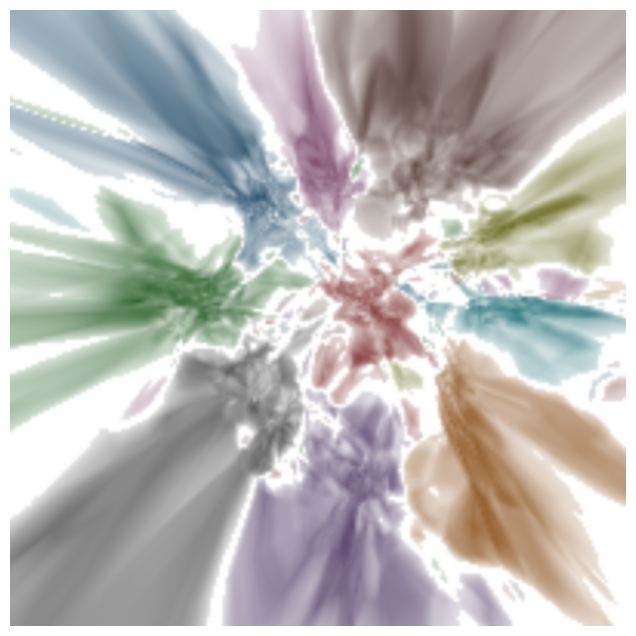

In [20]:
import json
import os
from singleVis.SingleVisualizationModel import VisModel
from singleVis.projector import TimeVisProjector
model = VisModel(ENCODER_DIMS, DECODER_DIMS)

projector = TimeVisProjector(vis_model=model, content_path=REF_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")

I = np.eye(512)
from representationTrans.trans_visualizer_border import visualizer
# from representationTrans.visualizer import visualizer
vis = visualizer(ref_provider, I,I, np.dot(ref_train_data, I), projector, 200,[[]],'tab10')
save_dir = os.path.join('/home/yifan/projects' , "imgcontrast")
# os.makedirs(save_dir)

vis.savefig(200, path=os.path.join("/home/yifan/projects/deepdebugertool/DLVisDebugger/alignment_evaluation/img1.png"))

Computing decision regions ...


100%|██████████| 200/200 [00:00<00:00, 9104.69it/s]
../representationTrans/trans_visualizer_border.py:186: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  train_data = self.data_provider.train_representation(epoch)[self.indicates]
../representationTrans/trans_visualizer_border.py:187: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  train_labels = self.data_provider.train_labels(epoch)[self.indicates]
../representationTrans/trans_visualizer_border.py:188: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; us

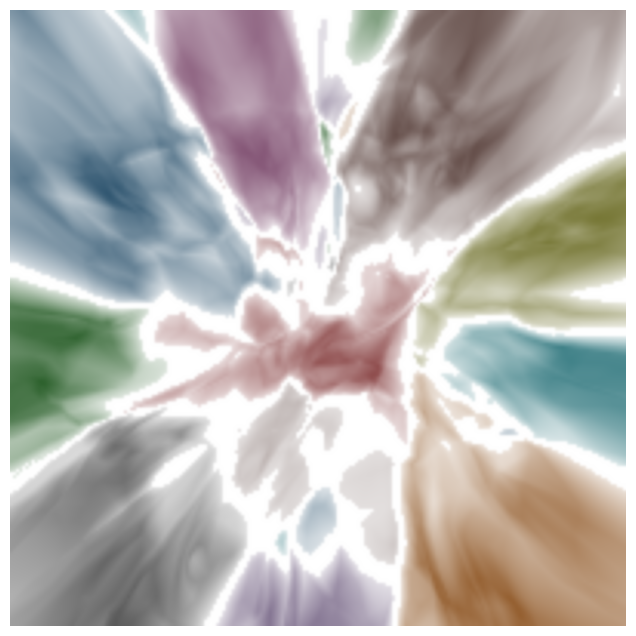

In [63]:
import json
import os
from singleVis.SingleVisualizationModel import VisModel
from singleVis.projector import TimeVisProjector
model = VisModel(ENCODER_DIMS, DECODER_DIMS)

projector = TimeVisProjector(vis_model=model, content_path=CLEAN_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")

I = np.eye(512)
from representationTrans.trans_visualizer_border import visualizer
# from representationTrans.visualizer import visualizer
vis = visualizer(tar_provider, I,I, np.dot(tar_train_data, R_n.detach().numpy()), projector, 200,[[]],'tab10')
save_dir = os.path.join('/home/yifan/projects' , "imgcontrast")
# os.makedirs(save_dir)

vis.savefig(200, path=os.path.join("/home/yifan/projects/deepdebugertool/DLVisDebugger/alignment_evaluation/img2.png"))

Computing decision regions ...


100%|██████████| 250/250 [00:00<00:00, 2322.22it/s]


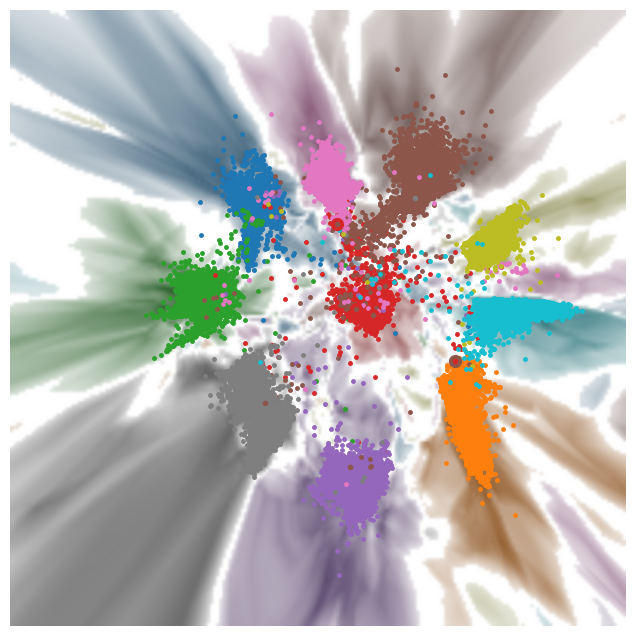

In [126]:
import json
import os
from singleVis.SingleVisualizationModel import VisModel
from singleVis.projector import TimeVisProjector
model = VisModel(ENCODER_DIMS, DECODER_DIMS)

projector = TimeVisProjector(vis_model=model, content_path=REF_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")

I = np.eye(512)
from representationTrans.trans_visualizer_border import visualizer
# from representationTrans.visualizer import visualizer
vis = visualizer(tar_provider, S_s.detach().numpy(),I, np.dot(ref_train_data, I), projector, 200,[],'tab10')
save_dir = os.path.join('/home/yifan/projects' , "imgcontrast")
# os.makedirs(save_dir)

vis.savefig(200, path=os.path.join("/home/yifan/projects/deepdebugertool/DLVisDebugger/alignment_evaluation/img1.png"))